In [3]:
import pandas as pd


In [4]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}


def race_combine_other(row):
    """Combines the values for the other races with american indian, hawaiian, etc"""
    return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])


def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]
    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def preprocess_race_df(df, year):
    remove_labels(df)
    df['HD01_VD07'] = race_df.apply(race_combine_other, axis=1)
    return preprocess_df(df, year, race_column_map)


def preprocess_income_df(df, year):
    remove_labels(df)
    return preprocess_df(df, year, income_column_map)


In [24]:
# We merge data into the income df


def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

# states = ['ny']
states = ['philly']
years = [str(yr) for yr in range(2012, 2017)]
# years = [str(yr) for yr in [2012]]
states_dfs = {}
for state in states:
    df = None
    for year in years:
        income_filename = get_filename(state, year, 'income')
        income_df = pd.read_csv(income_filename)
        # print(income_df.head())
        income_df = preprocess_income_df(income_df, year)
        # print(income_df.head())
        if df is None:
            df = income_df
        else:
            df = add_df(df, income_df)          
        race_filename = get_filename(state, year, 'race')
        race_df = pd.read_csv(race_filename)
        race_df = preprocess_race_df(race_df, year)
        # print(race_df.head())
        df = add_df(df, race_df)
        # print(df.head())
    states_dfs[state] = df

print(len(states_dfs))
states_dfs['philly'].head()

1


,2012 median income,2012 median income margin of error,2012 race: total households,2012 race: total households margin of error,2012 race: White,2012 race: Black,2012 race: Asian,2012 race: Other,2012 race: 2 or more races,2013 median income,...,2015 race: 2 or more races,2016 median income,2016 median income margin of error,2016 race: total households,2016 race: total households margin of error,2016 race: White,2016 race: Black,2016 race: Asian,2016 race: Other,2016 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
42101000100,75505,6605,3183,381,2773,147,155,52,56,81987,...,90,103772,11761,4012,476,3020,500,358,36,98
42101000200,49928,9068,2009,351,706,44,1231,19,9,51585,...,64,50455,22642,2563,457,825,156,1389,59,134
42101000300,71250,11758,3509,423,2595,271,509,32,102,73357,...,77,93036,15233,3530,300,2740,150,447,46,147
42101000401,30000,7215,2287,298,1319,261,564,13,130,44943,...,37,57604,10786,2666,245,1605,346,663,8,44
42101000402,44805,6432,3021,241,2715,61,184,0,61,46088,...,45,70038,14655,3202,367,2721,178,249,0,54


In [34]:
# Save the giant dataframes to CSV
for state, df in states_dfs.items():
    filename = get_filepath(state) + 'race_and_income_data.csv'
    df.to_csv(filename)

In [35]:
import geopandas as gpd

In [36]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Neighborhood',
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)
    

shapefile_df = get_nyc_shapefile()

shapefile_df.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,geoid
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...,36085000900
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...,36061009800
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...,36061010000
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,36061010200
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,36061010400


In [37]:
# TODO: do this differently for different cities
shapefile_attributes = nyc_shapefile_attributes

# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head()

,Neighborhood,shape_area,shape_leng,geometry
geoid,,,,
36085000900,West New Brighton-New Brighton-St. George,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
36061009800,Turtle Bay-East Midtown,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
36061010000,Turtle Bay-East Midtown,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
36061010200,Midtown-Midtown South,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
36061010400,Midtown-Midtown South,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


In [38]:
merged_shapes = shapefile_df.merge(states_dfs['ny'], on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (2165, 58)


,Neighborhood,shape_area,shape_leng,geometry,2012 median income,2012 median income margin of error,2012 race: total households,2012 race: total households margin of error,2012 race: White,2012 race: Black,...,2016 race: 2 or more races,2017 median income,2017 median income margin of error,2017 race: total households,2017 race: total households margin of error,2017 race: White,2017 race: Black,2017 race: Asian,2017 race: Other,2017 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
36085000900,West New Brighton-New Brighton-St. George,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...,63421,19913,2276,275,667,823,...,72,55250,14102,1757,285,592,941,110,22,92
36061009800,Turtle Bay-East Midtown,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...,101214,10485,7150,609,5801,143,...,72,134500,34808,7350,713,6216,171,789,87,87
36061010000,Turtle Bay-East Midtown,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...,85938,19868,1699,208,1247,56,...,10,106705,26125,1771,202,1391,32,215,111,22
36061010200,Midtown-Midtown South,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,43914,75182,267,97,258,4,...,6,167500,62247,126,68,90,2,7,22,5
36061010400,Midtown-Midtown South,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,74000,45597,1036,151,856,28,...,0,120217,20023,1008,138,729,25,194,60,0


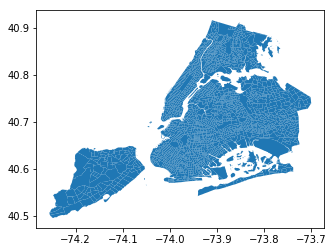

In [39]:
%matplotlib inline
merged_shapes.plot()

In [40]:
to_filename = get_filepath('ny') + 'nyc_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')

saving to  ../data/ny/nyc_census_tracts.geojson
saved
